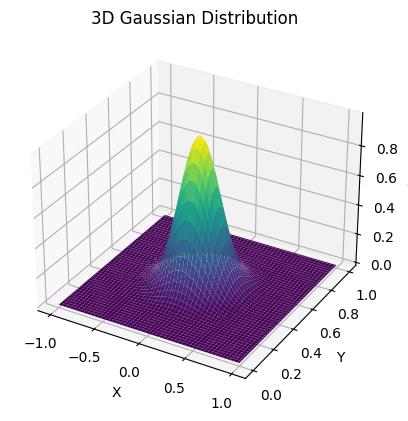

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the parameters
A = 1.0  # Amplitude
σx = 0.2  # Standard deviation along the x-axis
μy = 0.5  # Mean along the y-axis
σy = 0.1  # Standard deviation along the y-axis

# Create a grid of x and y values
x = np.linspace(-1, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Calculate the Gaussian distribution
Z = A * np.exp(-((X - 0)**2 / (2 * σx**2) + (Y - μy)**2 / (2 * σy**2)))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('3D Gaussian Distribution')

plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the 2D Gaussian distribution
x = np.linspace(-1, 1, 100)  # x coordinates ranging from -1 to 1
y = np.ones_like(x)  # Unified y coordinates (all ones)
X, Y = np.meshgrid(x, y)

# Calculate the 2D Gaussian distribution
mean = 0
std_dev = 0.3
gaussian_distribution = np.exp(-((X - mean) ** 2) / (2 * std_dev ** 2))

# Create a heatmap-like plot
plt.imshow(gaussian_distribution, extent=[-1, 1, 0, 1], origin='lower',
           cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Gaussian Distribution with Color')
plt.show()


KeyboardInterrupt: 

In [ ]:
import numpy as np

def generate_2d_gaussian(batch_x, batch_y, mean=0, std_dev=0.3):
    """
    Generate 2D Gaussian values at specified x, y coordinates.

    Args:
        batch_x (array-like): Array of x coordinates.
        batch_y (array-like): Array of y coordinates (unified).
        mean (float): Mean of the Gaussian distribution.
        std_dev (float): Standard deviation of the Gaussian distribution.

    Returns:
        array-like: 2D array of values corresponding to the input coordinates.
    """
    X, Y = np.meshgrid(batch_x, batch_y)
    gaussian_distribution = np.exp(-((X - mean) ** 2) / (2 * std_dev ** 2))
    return gaussian_distribution

# Example usage:
x = np.linspace(-1, 1, 100)  # x coordinates ranging from -1 to 1
y = np.ones_like(x)  # Unified y coordinates (all ones)

# Generate values for the provided coordinates
values = generate_2d_gaussian(x, y)

# You can now use the 'values' array as needed.
print(values.shape)
# plt.plot(values)

(100, 100)


In [ ]:
import tensorflow as tf
x = tf.random.uniform([256, 1], minval=-1, maxval=1)
t = tf.random.uniform([256, 1], minval=0, maxval=1)
std_dev = 0.3
nu_map = np.where(t >= 0.5, np.exp(-((x - 0) ** 2) / (2 * std_dev ** 2)), 0)
     # gaussian_distribution
print(nu_map.shape)

(256, 1)


Epoch 0, Loss: 0.03243361413478851
Epoch 100, Loss: 0.002241352340206504
Epoch 200, Loss: 0.0012857040856033564
Epoch 300, Loss: 0.0013343552127480507
Epoch 400, Loss: 0.0015245245303958654
Epoch 500, Loss: 0.0012545143254101276
Epoch 600, Loss: 0.001157561200670898
Epoch 700, Loss: 0.0010736229596659541
Epoch 800, Loss: 0.0009673894965089858
Epoch 900, Loss: 0.00111824506893754
Epoch 1000, Loss: 0.0010154129704460502
Epoch 1100, Loss: 0.0010732471710070968
Epoch 1200, Loss: 0.000938782119192183
Epoch 1300, Loss: 0.0009583035134710371
Epoch 1400, Loss: 0.0008512865751981735
Epoch 1500, Loss: 0.0008835215703584254
Epoch 1600, Loss: 0.0009537611622363329
Epoch 1700, Loss: 0.0008156178519129753
Epoch 1800, Loss: 0.0006386091117747128
Epoch 1900, Loss: 0.0007247459725476801
800/800 [==============================] - 0s 262us/step
u_pred_shape: (100, 256)


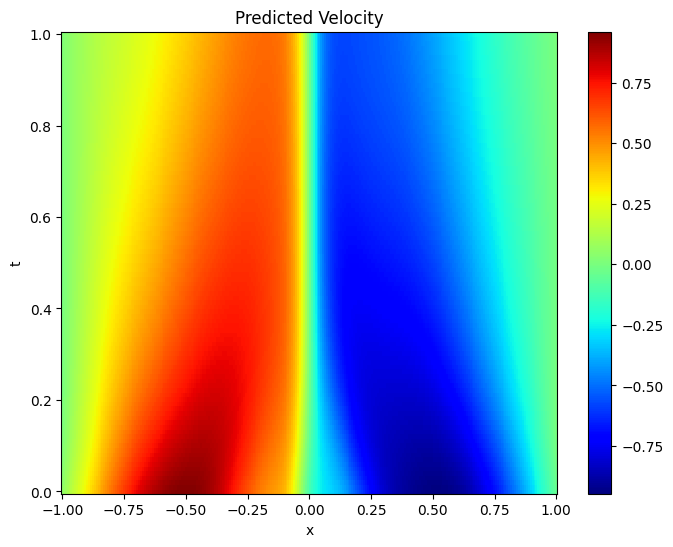

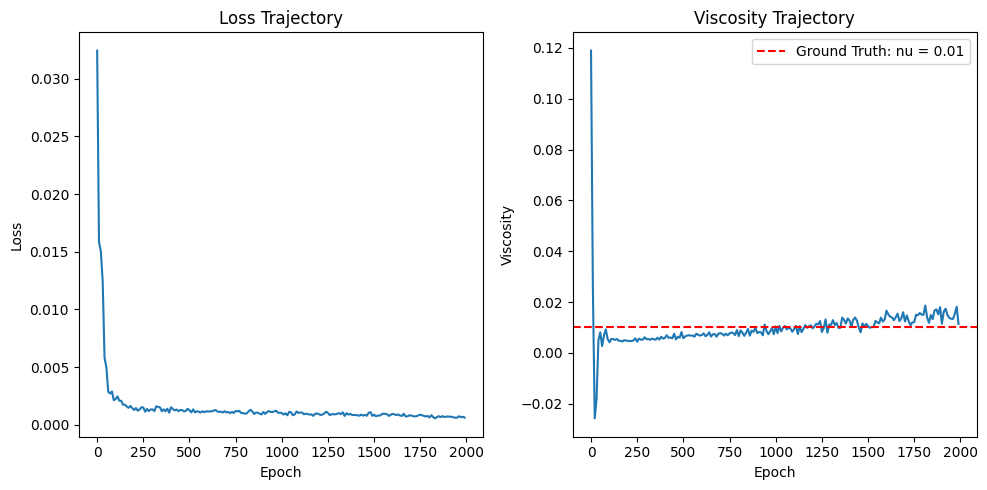

<tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.01180749>


In [13]:
# v13 10 Oct 2023 
# artificial viscosity - achieved with TF variables
# made adjustment on IC/BC loss functions

## parametric method:
# ###### the shock width decreases with time ###### and loss and nu_max trajectory shows reasonable.
# However the theta_map and nu_map show random values all over the place without the "Gaussian distribution"
# Try designate the Gaussian distribution over the viscosity map


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

# data = scipy.io.loadmat('burgers_shock.mat')
# Exact = data['usol']
# Exact_u = np.real(Exact)

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = tf.Variable(initial_value=tf.ones([]) * viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        # initial value can be tf.random.uniform(shape=(), minval=0.1, maxval=1.0)
        self.theta = tf.Variable(initial_value=tf.ones([256, 1]) * 0.5, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="viscosity_map_coefficient")
        self.t_shock = tf.Variable(initial_value=0.5, 
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="shock_happen_time")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

def viscosity_mapping(x, t, epoch):
    std_dev = 0.3
    nu_map = domain.theta * np.exp(-((x - 0) ** 2) / (2 * std_dev ** 2)) # gaussian_distribution

    # TODO put learnable t_shock
    # nu_map = domain.theta * np.where(t >= domain.t_shock, np.exp(-((x - 0) ** 2) / (2 * std_dev ** 2)), 0) # gaussian_distribution
    
    # _nu_map = theta * (x + t) # Calculate the viscosity for each pair of x and t
    # Bound the nu values to between 0 and 1
    viscosity = domain.viscosity * tf.sigmoid(nu_map) 
    storage = [x, t, domain.theta, viscosity, epoch, domain.t_shock]
    
    return viscosity, storage #TODO link the x and t to viscosity maps
# TODO merge viscosity into the data storage

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size, epoch):
    # define a viscosity map, displaying the preference of AV on domain
    
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")
        
        # define the parametric viscosity map with the collocation points in the residual learning batch
        # keep record of the parameters: x_coords, t_coords, theta, product of nu_max and nu_map
        viscosity_map, parameter_storage = viscosity_mapping(x, t, epoch)

        # Define the Burgers equation residual
        residual = u_t + u * u_x - viscosity_map * u_xx
        # viscosity_map: nu_max * nu_map
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = 32
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = 32
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, domain.x_min, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, domain.x_max, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(tf.reduce_max(domain.viscosity)) # square the maximum element
    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            viscosity_loss
    
    # print("viscosity map: ",  domain.viscosity * _viscosity_map) # 256,1
    return loss, viscosity_map, parameter_storage

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    loss_history = []
    viscosity_history = []
    # theta_history = []

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss, viscosity_map, parameter_s = physics_informed_loss(network, domain, x_batch, t_batch, batch_size, epoch)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] + \
                        [domain.theta] # + [domain.t_shock]

        gradients = tape.gradient(loss, variable_list)
        optimizer.apply_gradients(zip(gradients, variable_list))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            loss_history.append(loss.numpy())
            viscosity_history.append(tf.reduce_max(domain.viscosity).numpy())
            # theta_history.append(domain.theta)
    
        # if epoch % 4999 == 0:
            # print("epoch reached 4999")
        # for the last epoch
            # output the x_batch and t_batch from the PI_loss function
            # match the x and t to its velocity map and velocity max

    return network, loss_history, viscosity_history, viscosity_map, parameter_s
# worked after changing it to "network"
#TODO: showed error: NameError                        Traceback (most recent call last)
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     139 network = create_network()
#     141 # Train the model using PINNs
# --> 142 model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)
#     144 # Visualize the results
#     145 visualize_results(model, domain)
# 
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     106     if epoch % 100 == 0:
#     107         print(f"Epoch {epoch}, Loss: {loss.numpy()}")
# --> 109 return model
# 
# NameError: name 'model' is not defined

# Visualize the results
def visualize_results(model, domain, loss_history, viscosity_history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], t_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, viscosity_history)
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 256
    num_t = 100
    viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v)
    num_epochs = 2000

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, loss_history, viscosity_history, viscosity_map, parameter_s = train_model(network, 
                                                         domain, 
                                                         num_epochs, 
                                                         learning_rate=0.01, 
                                                         batch_size=256
                                                         )

    # Visualize the results
    u_pred_grid = visualize_results(model, 
                                    domain, 
                                    loss_history, 
                                    viscosity_history, 
                                    num_epochs)

    #TODO compare the u_pred_grid with the analytical solution

    print(domain.viscosity)




(256, 1)
<tf.Variable 'shock_happen_time:0' shape=() dtype=float32, numpy=0.5>
epoch: 1999
t when shock happens:  0.5


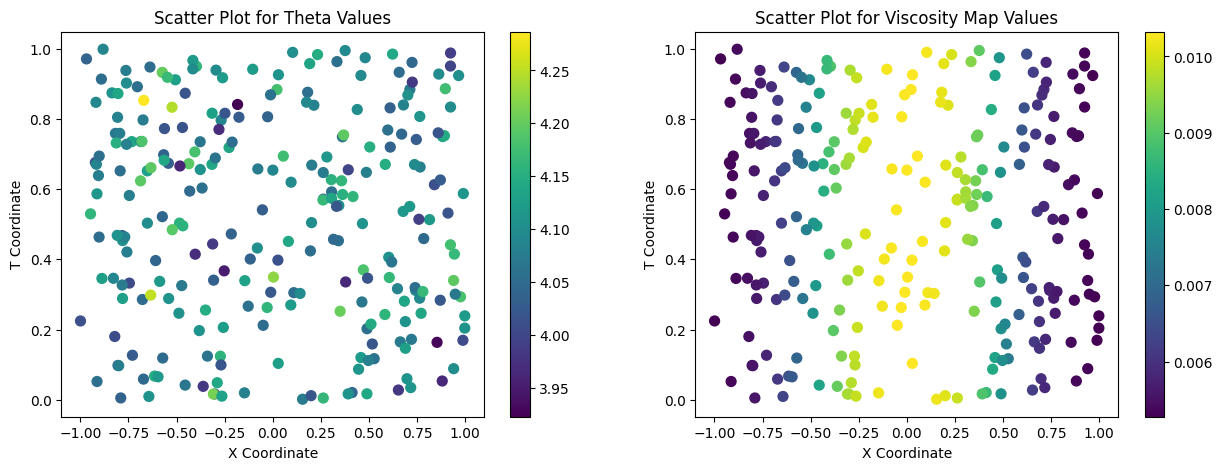

In [9]:
print(parameter_s[0].shape) # 0x 1t 2theta 3viscosity 4epoch 5t_shock
print(parameter_s[5])
# Assuming 'parameter_s' is a list of three NumPy arrays with shape (256, 1)
# Assuming 'parameter_s' is a list of four NumPy arrays or lists
x_coords = np.array(parameter_s[0])  # Convert to NumPy array
y_coords = np.array(parameter_s[1])  # Convert to NumPy array
theta = np.array(parameter_s[2])     # Convert to NumPy array
nu = np.array(parameter_s[3])         # Convert to NumPy array
epoch = np.array(parameter_s[4])
t_shock = np.array(parameter_s[5])
print("epoch:", epoch)
print("t when shock happens: ", t_shock)

# Create the scatter plot
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
scatter1 = plt.scatter(x_coords, y_coords, c=theta, cmap='viridis', s=50)  # Adjust 's' for point size
plt.colorbar(scatter1)
plt.xlabel('X Coordinate')
plt.ylabel('T Coordinate')
plt.title('Scatter Plot for Theta Values')

plt.subplot(1,2,2)
scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
plt.colorbar(scatter2)
plt.xlabel('X Coordinate')
plt.ylabel('T Coordinate')
plt.title('Scatter Plot for Viscosity Map Values')
plt.show()
